## Summary of what we are looking at 
- how we define success. 
- In most cells, give a breif descrition of what we are doing and were files come from.
- have one cell that is markdown, then code cell
- combine cells
- describe visualization. What is the take away, what is the message.
- will have to make some judgement calls on what we could leave out.
- dont need to explain code for vidualization, just what the visualization says.

# How to Get Your Name in Shining Lights
### Alexis Metzler, Benjamin Millunchick, Catherine Grillo

## INTRO!

In [1]:
#importing of all of the packages that will be used later
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

- The streaming data was retrieved from https://www.kaggle.com/ruchi798/movies-on-netflix-prime-video-hulu-and-disney and contains data on all movies that are available for viewing on Netflix, Hulu, Prime Video, and Disney+ along with genre, target age group, and runtime information for most entries.
- The award data was retrieved from https://www.kaggle.com/theacademy/academy-awards and contains data on who won and was nominated for the academy awards dating back to the first ceremony in 1928 through the ceremonry in 2016.
- The imdb data was retrieved from https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset (specifilly the movie.csv) and contains data for the imdb ratings for all movies that as of 01/01/2020 had more than 100 votes.

Full documentation for each of the datasets can be found at their respective links


In [2]:
# importing of all the data

award = pd.read_csv('oscars.csv')

streaming = pd.read_csv('MoviesOnStreamingPlatforms_updated.csv').set_index('ID').drop('Unnamed: 0', axis = 1)

imdb = pd.read_csv('imdb.csv')

# just a tiny bit of preprocessing, because we intend to later look at trends over time we will want to be able to make use of the date released as a datetime object
imdb['date_published'] = pd.to_datetime(imdb['date_published'], errors = 'coerce')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Alexis' Work
- age group vs imdb rating scatter plot
- genre vs imdb rating set of histograms

Because we won't want to be using all of the columns of the full data sets we will only grab the columns needed for our analysis

In [ ]:
# The next few lines of code are grabbing specific subsets and calculating columns we will need later
imdb_subset = imdb[['title','original_title','date_published','avg_vote','budget','usa_gross_income','worlwide_gross_income']]
streaming_subset = streaming[['Title','Genres','Age','Runtime','Country']]
streaming_subset['Streaming'] = streaming[['Netflix','Hulu','Prime Video','Disney+']].apply(sum,axis = 1)

# We then merged these two subset into a larger set that can be used.
joined = pd.merge(streaming_subset,imdb_subset, how = 'inner',right_on = 'original_title',left_on = 'Title')

### Do movies targeted at different age groups perform differently?
One thing that we were interested in was whether movies aimed at different age groups would be rated better or worse than expected.

In [ ]:
# by creating a pivot table we are able to create a stacked histogram of the data grouped by Age
joined.pivot(columns = 'Age')['avg_vote'].plot(kind = 'hist', stacked=True, color = ['olivedrab','lightsalmon','cornflowerblue','orchid','khaki','tan'])
plt.title('average rating by age group')
plt.xlabel('average vote (out of 10)')

# in order to confirm our observations on the histogram we are able to generate discriptive statistics by using .groupby
joined.groupby('Age').agg([np.nanmean,np.std])[['avg_vote']]

We started with a histogram. When looking at these plots we noted that all of the groups appeared to peak in the $5.5 \pm 0.5$ range and had similar spreads. This was confirmed by the statistics that we generated for each group. This showed that while there were variations in the mean ratings, none of them were outside a standard devation and would be considered statistically significant.

### Do different generes of movies perform differntly?
The next question that we wanted to answer was whether different genres perform differently. We did this by generating a plot of the mean values with error bars the length of a standard deviation. 

In [ ]:
genres = []
vals=[]
errors = []

# because each movie can be listed under multiple genres we must first extract a list of all the individual genres
for x in joined['Genres'].unique():
    gs = str(x).split(',')
    for gen in gs:
        if gen in genres:
            continue
        else:
            genres.append(gen)

# we can then generate discriptive statistics based upon all movies that are listed under a certain genre. 
# Keep in mind however that this means many movies are being double counted as they are listed until multiple genres
for g in genres:
    movies = joined[joined['Genres'].map(lambda x: g in str(x))]
    vals.append(np.nanmean(movies['avg_vote']))
    errors.append(np.std(movies['avg_vote']))
    
fig0,ax0 = plt.subplots(figsize=[10,5])
plt.xticks(rotation = 90)
ax0.plot(genres,np.full(len(genres),5.45), c = 'orchid')
ax0.plot(genres,np.full(len(genres),np.nanmean(joined['avg_vote'])), c = 'lightsalmon')
ax0.errorbar(genres, vals, errors,fmt = '.', c='olivedrab')
ax0.legend(['Population Mean','5.45','Values'])
ax0.set_ylabel('Average Vote (Out of 10)')
ax0.set_xlabel('Genre')
ax0.set_title('Average Vote Grouped by Genre')
ax0.legend(['5.45','Population Mean','Values'])

Note, that the points for <i>Game-Show</i> and <i>News</i> were generated from samples of 3 and 1 respectively, this makes these points hard to generalize to a general trend. For ease of interpretation we have placed a 2 horizontal lines, one of which lies at the population mean average vote and one which lies at 5.45, a value that falls within the standard devation of all non-negligable points. From looking at these points and the two lines, we can see that while all of the ranges include 5.45, the movies which no not have a listed genre does not include the mean of the current dataset but given the length of the error bars we can say that none of the values vary significatly from each other, or from the population.

### Do movies that earn more get better rated?
Can you buy a good movie? We wanted to know if having a massive budget increases the likelihood of your movie being well recieved by the public

In [ ]:
doll = joined[joined['budget'].map(lambda x: '$' in str(x))]
doll['budget'] = doll['budget'].map(lambda x : float(str(x).replace('$','')))

fig1,ax1 = plt.subplots()
ax1.scatter(doll['avg_vote'],doll['budget'], s=1, c='olivedrab')
ax1.set_yscale('symlog')
ax1.set_ylabel('Budget ($)')
ax1.set_xlabel('Average Vote')
ax1.set_title('Rating vs. Budget')

# in order to quantify our results we decided to calculate the correlation coefficient for the two variables
np.corrcoef(doll['avg_vote'],doll['budget'])[0][1]

When looking at this graph it appears as though there isn't any relationship between the two variables as the points don't appear to be showing any strong trend. This is supported by the correlation coefficient of 0.29498 which tells us that less that 30% of the variation in rating can be attributed to variations in budget.

### Are movies on different streaming platforms get better rated?

Another factor we were considering was whether the presence of a movie of a streaming platform is an indicator of a good movie, the logic being that streaming platforms wouldn't pay for the rights to bad movies.

In [ ]:
platforms = ['Netflix','Hulu','Prime Video','Disney+']

platvals=[]
platerrors = []

# Calculate means and standard deviations for each of the streaming platforms
for plat in platforms:
    movies = streaming[streaming[plat]==1]
    platvals.append(np.nanmean(movies['IMDb']))
    platerrors.append(np.std(movies['IMDb']))

fig2,ax2 = plt.subplots()
plt.xticks(rotation = 30)
plt.errorbar(platforms, platvals, platerrors,fmt = '.', c='olivedrab')
ax2.plot(platforms,np.full(len(platforms),np.nanmean(imdb['avg_vote'])), c = 'orchid')
ax2.legend(['Population Mean','Values'])
ax2.set_xlabel('Platform')
ax2.set_ylabel('Average Vote (Out of 10)')
ax2.set_title('Average Vote across streaming platforms')

#generate statistics based on number of streaming platforms
joined.groupby('Streaming').agg([np.nanmean, np.std])['avg_vote']

When looking at this plot, we see the means and standard deviation for each of the platforms which are inlcuded in this set. The population mean rating for the entire IMDb dataset is also shown. We can see that for all of the platforms except for Prime Video the mean rating is above that for the entire population, but for all of the platforms the population mean is included in the standard deviation. As a followup question, we wanted to know whether being on more streaming platforms meant that a movie was better. We generated desciptive statistics based upon the number of streaming platforms and saw that while there did appear to be an upward trend between number of streaming platforms and average rating, it wasn't significant enough based upon the respective standard deviations.

# Ben's Work

In [3]:
def winner_nominated(x):
    if x != 1:
        return 0
    else:
        return x
award['Winner'] = award['Winner'].apply(winner_nominated)

### Do better rated movies win more awardsscatterplot compairing imdb ratings and rotton tomatoes

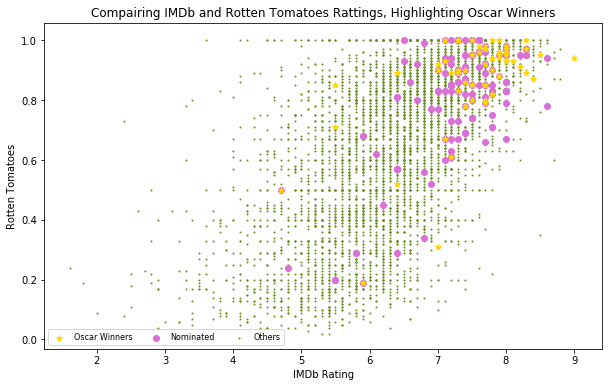

In [5]:
# Creating subset to answer this question
df = streaming[['Title', 'IMDb', 'Rotten Tomatoes', 'Year']].merge(award[['Winner','Film']], left_on='Title', right_on='Film', how='left')

# Making objects into numbers so I can work with them
def percent_to_float(x):
    try:
        x = x.strip('%')
        return float(x)/100
    except:
        return np.nan
df['Rotten Tomatoes'] = df['Rotten Tomatoes'].apply(percent_to_float)

# Sepparating out those who won, were nominated, and everyone else
winners = df[df['Winner']==1]
nominated = df[df['Winner']==0]
other = df[np.isnan(df['Winner'])]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
other = plt.scatter(other['IMDb'], other['Rotten Tomatoes'], c='olivedrab',s=1)
nominated = plt.scatter(nominated['IMDb'], nominated['Rotten Tomatoes'], c='orchid')
winners = plt.scatter(winners['IMDb'], winners['Rotten Tomatoes'], c='gold', marker='*')
plt.title('Compairing IMDb and Rotten Tomatoes Rattings, Highlighting Oscar Winners')
plt.xlabel("IMDb Rating")
plt.ylabel("Rotten Tomatoes")
plt.legend((winners, nominated, other), ('Oscar Winners', 'Nominated', 'Others'), scatterpoints=1, loc='lower left', ncol=3, fontsize=8)
plt.show()

The first thing that this plot is showing is, for the most part, Rotten Tommatoes and IMDb are consistant. Good movies on one will be a good movie on another. However, Rotten Tommatoes is a little more generouse with their ratings. The other thing this plot shows is that gor the most part movies people liked receave nominations and awards. There are a couple outliers, but a large cluster at the top.

### How has the funding of movies increased over time?

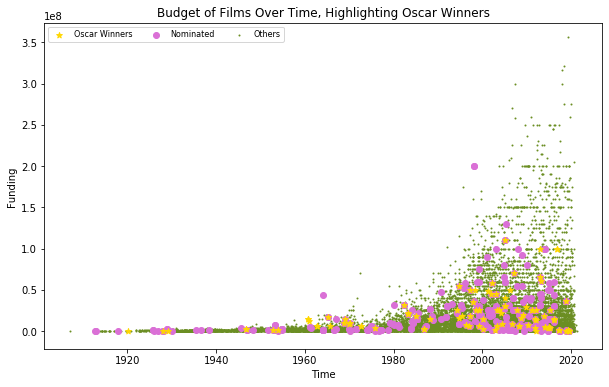

In [12]:
# Creating subset to answer this question
df2 = imdb[['title', 'budget', 'avg_vote', 'date_published']].merge(award[['Winner','Film']], left_on='title', right_on='Film', how='left')

# Making objects into numbers so I can work with them
def budget(x):
    try:
        x=x.strip('$ ')
        return int(x)
    except:
        return np.nan
df2['budget'] = df2['budget'].apply(budget)

# Sepparating out those who won, were nominated, and everyone else
winners2 = df2[df2['Winner']==1]
nominated2 = df2[df2['Winner']==0]
other2 = df2[df2['Winner']!=1]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
other = plt.scatter(other2['date_published'], other2['budget'], c='olivedrab', s=1)
winners = plt.scatter(nominated2['date_published'], nominated2['budget'], c='orchid')
winners = plt.scatter(winners2['date_published'], winners2['budget'], c='gold', marker='*')
plt.title('Budget of Films Over Time, Highlighting Oscar Winners')
plt.xlabel("Time")
plt.ylabel("Funding")
plt.legend((winners, nominated, other), ('Oscar Winners', 'Nominated', 'Others'), scatterpoints=1, loc='upper left', ncol=3, fontsize=8)
plt.show()

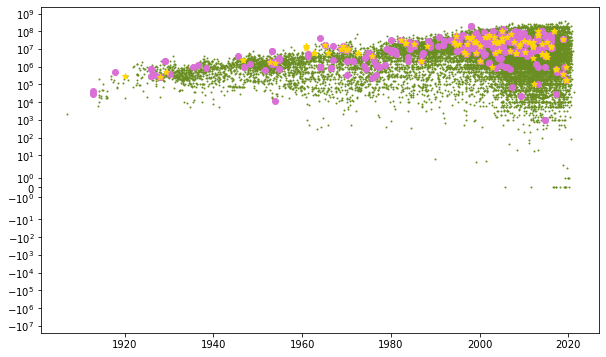

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 6))
other = plt.scatter(other2['date_published'], other2['budget'], c='olivedrab', s=1)
winners = plt.scatter(nominated2['date_published'], nominated2['budget'], c='orchid')
winners = plt.scatter(winners2['date_published'], winners2['budget'], c='gold', marker='*')
ax1.set_yscale('symlog')
plt.show()

As expected, the budgets for movies has grown exploded. But what is good to see is that for recent movies at least, you can't really buy awards. Lot of nominations and winners are towards the bottom. However, if we look at the log numbers it doesnt actually look to matter? we will talk about this as a group.

### How have ratings of movies change over time?

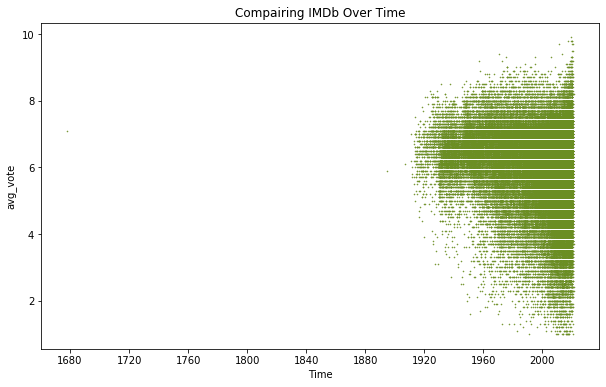

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(imdb['date_published'], imdb['avg_vote'], c='olivedrab', s =.3)
plt.title('Compairing IMDb Over Time')
plt.xlabel("Time")
plt.ylabel("avg_vote")
plt.show()

So there is a little bit of a recency bias, but thats not suprising. What I was really checking for is if there was a difference in how newer and older mives were rated on IMDb. And, kinda like yeah. They are rated maube a little higher on average than newer movies. I expect this is becuase people only choose to watch, then rate, old movies that are already known to be good.

fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(df2['budget'], df2['avg_vote'], c='black', s =.3)
plt.title('Compairing IMDb Over Time')
ax.set_yscale('symlog')
plt.xlabel("budget")
plt.ylabel("avg_vote")
plt.show()### Movies budget vs. rating

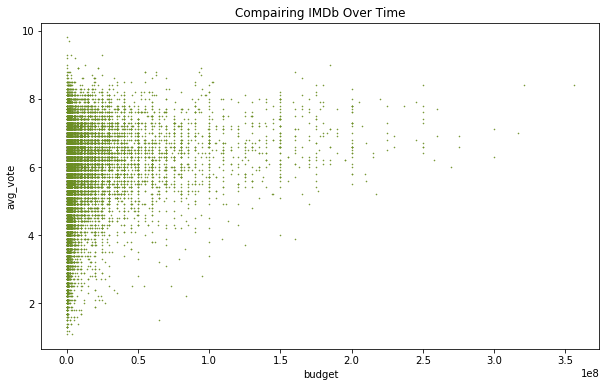

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(df2['budget'], df2['avg_vote'], c='olivedrab', s =.3)
plt.title('Compairing IMDb Over Time')
#ax.set_yscale('symlog')
plt.xlabel("budget")
plt.ylabel("avg_vote")
plt.show()

So, there does seem to be some evidance here that if you spend more you will get a better movie. However, that may just be because there are more low budget movies

# Cat's Work

### Do better rated movies receive more awards/nominations?

We were interested to see if better rated movies by critics and IMDb users will receive more nominations or win more awards. Further, we wanted to compare ratings and winnings across time periods in order to break the data down into more digestable chunks. The time periods we selected are the golden age of Hollywood (1920-1969), the rise of home video (1980-2000), and the last ten years (2010-2020). We felt these time periods were the most notable points in the movie industry.

In [ ]:
# the next two lines are reading in the IMDb data, and converting the date_published to datetime
m = pd.read_csv('imdb.csv')
m['date_published'] = pd.to_datetime(m['date_published'], errors = 'coerce')



# function to convert the nan values in the winners column of the oscar data base to be 1 if nominated, and 2 if nominated and won
def nan_fix(df):
    if str(df) == 'nan':
        return 1
    if df == 1.0:
        return 2

# the next three lines of code are applying a function to change the winners column to numbers that represent whether the movie won or not
a = award[['Winner', 'Film']]
a['Winner'] = a['Winner'].apply(nan_fix)
a = a.rename(columns={"Film": "title"})



# the next two lines create the golden age of film df
m_golden = m[(m['date_published']>'1927-01-01')&(m['date_published']<'1969-12-31')]
m_golden = m_golden[['original_title', 'avg_vote', 'metascore']].rename(columns={'original_title':'title'})

# the next few lines are the golden age of film df merged with oscar data to create a column displaying if a movie has been nominated/won, or not nominated
merge_golden = m_golden.merge(a, how='left', on = 'title')
merge_golden = merge_golden.dropna(subset=['metascore'])
merge_golden['Winner'] = merge_golden['Winner'].fillna(0)

# finding the mean because if it is 0, we know the movie was not nominated,
# if it is 1.0, we know the movie was nominated but did not win,
# and if it is more than 1.0, we know the movie won an award
merge_golden = merge_golden.groupby('title').agg(np.mean)



# the next two lines create the movies during the rise of home video df
m_home = m[(m['date_published']>'1980-01-01')&(m['date_published']<'2000-12-31')]
m_home = m_home[['original_title', 'avg_vote', 'metascore']].rename(columns={'original_title':'title'})

# the next few lines are the rise of home video df merged with oscar data to create a column displaying if a movie has been nominated/won, or not nominated
merge_home = m_home.merge(a, how='left', on = 'title')
merge_home = merge_home.dropna(subset=['metascore'])
merge_home['Winner'] = merge_home['Winner'].fillna(0)

merge_home = merge_home.groupby('title').agg(np.mean)



# movies from the last 10 years
m_now = m[(m['date_published']>'2010-01-01')&(m['date_published']<'2020-12-31')]
m_now = m_now[['original_title', 'avg_vote', 'metascore']].rename(columns={'original_title':'title'})

# the last ten years df merged with oscar data to create column displaying if a movie has been nominated/won
merge_now = m_now.merge(a, how='left', on = 'title')
merge_now = merge_now.dropna(subset=['metascore'])
merge_now['Winner'] = merge_now['Winner'].fillna(0)

merge_now = merge_now.groupby('title').agg(np.mean)

Below is the code block that creates the figure with three scatterplots where the metascore (critic rating) is compared to the user rating and the nominations/winners are highlighted in purple. The green represents the movies that came out during that time period that were not nominated for Oscars. 

In [ ]:
fig_cat, (ax_golden, ax_home, ax_now) = plt.subplots(1,3, figsize=[25,5])

# golden age scatterplot
test_golden = merge_golden
lame_movies_golden = test_golden[test_golden['Winner'] == 0]
good_movies_golden = test_golden[test_golden['Winner'] != 0]
ax_golden.scatter(lame_movies_golden['metascore'], lame_movies_golden['avg_vote'], s=1, color='olivedrab')
ax_golden.scatter(good_movies_golden['metascore'], good_movies_golden['avg_vote'], s=10, color='orchid')
ax_golden.set_title('Metascore vs. User Ratings in the Golden Age of Hollywood', fontsize=14)
ax_golden.set_xlabel('Metascore', fontsize=12)
ax_golden.set_ylabel('User Rating', fontsize=12)

# rise of home videos scatterplot
test_home = merge_home
lame_movies_home = test_home[test_home['Winner'] == 0]
good_movies_home = test_home[test_home['Winner'] != 0]
ax_home.scatter(lame_movies_home['metascore'], lame_movies_home['avg_vote'], s=1, color='olivedrab')
ax_home.scatter(good_movies_home['metascore'], good_movies_home['avg_vote'], s=10, color='orchid')
ax_home.set_title('Metascore vs. User Ratings in the Rise of Home Video Era', fontsize=14)
ax_home.set_xlabel('Metascore', fontsize=12)
ax_home.set_ylabel('User Rating', fontsize=12)

# last 10 years scatterplot
test_now = merge_now
lame_movies_now = test_now[test_now['Winner'] == 0]
good_movies_now = test_now[test_now['Winner'] != 0]
ax_now.scatter(lame_movies_now['metascore'], lame_movies_now['avg_vote'], s=1, color='olivedrab')
ax_now.scatter(good_movies_now['metascore'], good_movies_now['avg_vote'], s=10, color='orchid')
ax_now.set_title('Metascore vs. User Ratings in the Last Ten Years', fontsize=14)
ax_now.set_xlabel('Metascore', fontsize=12)
ax_now.set_ylabel('User Rating', fontsize=12)

fig_cat.legend(['not nominated', 'nominated/won'], loc='upper right', prop={"size":13})

These scatterplots display a general trend that most movies that are nominated and/or win awards are both highly rated by critics (metascore) as well as users of IMDb

## Interesting things to Note - Honorable Mentions

We also had some questions we wanted to use the data to answer that did not relate to movie ratings specifically. The questions we posed are listed and answered below.

### What is the number of movies nominated for Oscars each year?

We were interested in seeing if the number of unique movies being nominated has been dropping. We wanted to see if this pattern would indicate that movies are receiving nominations in more categories, therefore taking the nomination away from other movies.

In [ ]:
# grouping by year and getting the count of unique movies that year
award_grouped = award.groupby('Year').nunique()

# make plot for the number of movies that are nominated each year for the oscars
xaxis = [int(x[-4:]) for x in list(award_grouped.index)]
plt.plot(xaxis, award_grouped['Film'], color='olivedrab')
plt.title('Number of Movies Nominated for an Oscar Each Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(np.arange(min(xaxis), max(xaxis)+1, 10.0))
plt.show()

The chart shows that the number of movies that are nominated each year reached a peak in the 1940s, and has since leveled out. We were hoping to find data that showed that less movies are nominated in recent years, meaning that few movies dominate all the awards. We were surpised to see that this has not been the general trend. While less movies are nominated now than in the mid 1900s, there seems to be a slight increase in the number of nominated movies after 2008, highlighting that more movies are being recognized for their work - which is a good thing.

### How many unique oscar winners are there each year?

We also had an interest in seeing if the number of unique movies actually <i>winning</i> the Oscars has been decreasing. We had a theory that less movies were winning more of the awards in recent years.

In [ ]:
# reading in the Oscar data and grouping by year to get the count of unique movies that year
award2_grouped = award[award['Winner'] == 1].groupby('Year').nunique()

# make a plot for the number of oscar winners each year 
xaxis2 = [int(x[-4:]) for x in list(award2_grouped.index)]
plt.plot(xaxis2, award2_grouped['Film'], color='olivedrab')
plt.title('Number of Oscar Winners Each Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Oscar Winners', fontsize=12)
plt.xticks(np.arange(min(xaxis2), max(xaxis2)+1, 10.0))
plt.show()

The chart highlights that the number of oscar winners per year has increased since the early 30s (which is expected due to both a lack of data), and leveled out. We expected an initial increase in the number of movies winning because as the years have progressed, more nomination categories have been created and there is more data on IMDb and the Oscar data highlighting movies and their nominations/wins.

### How has movie runtime changed over the years?
Something we were interested in was how movie runtime has changed over the years. We thought that possible with the decreased production costs of movies they would start getting longer as it became more affordable

In [ ]:
fig3,(ax_whole,ax_start,ax_recent) = plt.subplots(1,3, figsize=[25,5])
small = joined.dropna(subset = ['Runtime'])
means = small.groupby(small['date_published'].dt.year).transform('mean')[['Runtime']]

ax_whole.scatter(small['date_published'],small['Runtime'], s=1, color='olivedrab')
ax_whole_t = ax_whole.twiny()
ax_whole_t.plot(small['date_published'].dt.year,means, '.', color = 'orchid')
ax_whole.set_ylim(0,200)
ax_whole.set_xlim(right ='2021')
ax_whole_t.set_xlim(right =2021)
ax_whole.set_xlabel('Date Published')
ax_whole.set_ylabel('Runtime (min)')
ax_whole.set_title('Runtime over all points 1894 - 2020')

ax_start.scatter(small['date_published'],small['Runtime'], s=1, color='olivedrab')
ax_start_t = ax_start.twiny()
ax_start_t.plot(small['date_published'].dt.year,means, '.', color = 'orchid')
ax_start.set_ylim(0,200)
ax_start.set_xlim(right ='2000')
ax_start_t.set_xlim(right =2000)
ax_start.set_xlabel('Date Published')
ax_start.set_ylabel('Runtime (min)')
ax_start.set_title('Runtime of all points from 1894 - 2000')

ax_recent.scatter(small['date_published'],small['Runtime'], s=1, color='olivedrab')
ax_recent_t = ax_recent.twiny()
ax_recent_t.plot(small['date_published'].dt.year,means, '.', color = 'orchid')
ax_recent.set_ylim(0,200)
ax_recent.set_xlim('2000','2021')
ax_recent_t.set_xlim(2000,2021)
ax_recent.set_xlabel('Date Published')
ax_recent.set_ylabel('Runtime (min)')
ax_recent.set_title('Runtime of all points from 2000 - 2020')

fig3.legend(['Values'], loc='upper right', prop={"size":13}) #this is working :/ if someone else want to try and fix it I would be very appriciative

It appears that from the start of our data through the 1960s runtime was all over the place, but since then until the mid 2000s the runtime stablized with the yearly mean being denoted by the orchid points.

## What did we learn?